In [8]:
#from sklearn import linear_model
from torch import nn
from numpy.random import randint

import matplotlib.pyplot as plt
import pandas as pd
import numpy  as np
import torch  as tc

class SineActivation(nn.Module):
    def __init__(self): 
        super(SineActivation, self).__init__() 
    def forward(self, x):
        return tc.sin(x)
    
class Regressao_M(nn.Module):
    def __init__(self, neuronio, M, output=3, activation=nn.Mish(), creat_p=False, N_of_paramater=1):
        super().__init__()
        self.neuronio = neuronio
        self.M = M
        self.output = output
        self.creat_p = creat_p
        self.N_of_paramater = N_of_paramater

        # Lista para armazenar as camadas lineares
        self.hidden_layers = nn.ModuleList([nn.Linear(3, neuronio)])
        self.hidden_layers.extend([nn.Linear(neuronio, neuronio) for _ in range(M-1)])
        
        # Última camada linear
        self.output_layer = nn.Linear(neuronio, output)

        # Função de ativação
        self.activation = activation

        if creat_p:
            self.acceleration = nn.Parameter(tc.rand(N_of_paramater))
            #self.acceleration = nn.Parameter(tc.ones(N_of_paramater)*2)

    def forward(self, x):
        for layer in self.hidden_layers:
            x = self.activation(layer(x))
        x = self.output_layer(x)
        return x
    
#generation of data
def numerical_solution2(N,G0,c1,c2,c3,c4,tau,w,V0):
    def f(t,q,V):
        r=-q/tau+c1*V+c2*V**2+c3*V**3+c4*V**4
        return r
    def v(t,w):
        return V0*np.cos(w*t)
    Nc = 20
    dt = 4*np.pi/(N)/w

    n  = np.zeros(N)
    I  = np.zeros(N)
    V  = np.zeros(N)
    t  = np.zeros(N)
    n[0] = 6
    I[0] = 1
    t[0] = 0
    V[0] = v(t[0],w)
    for j in range(Nc):
        if j>1:
            n[0]=n[-1]
            I[0]=I[-1]
        for i in range(N-1):
        #RK4
            t[i+1]=t[i]+dt
            k1=dt*f(t[i],n[i],v(t[i],w));
            k2=dt*f(t[i]+dt/2,n[i]+k1/2,v(t[i]+dt/2,w));
            k3=dt*f(t[i]+dt/2,n[i]+k2/2,v(t[i]+dt/2,w));
            k4=dt*f(t[i]+dt,n[i]+k3,v(t[i]+dt,w));
            n[i+1]=n[i]+(1.0/6.0)*(k1+k4+2.0*(k2+k3))
            I[i+1]=(G0+n[i+1])*v(t[i+1],w)
            V[i+1]=v(t[i+1],w)
    return t,I,V,n


### EDO solution

In [9]:
def treino(lr_,neuronio_,camadas,fun_activation,epochs=1000,step_size_=500,N=1000,G0=1,c1=1.0,c2=1,c3=0,c4=0,tau=1,w=1,V0=1):
    # Criando os dados de treino
    time,corrent,d_potencial,x_true = numerical_solution2(N,G0,c1,c2,c3,c4,tau,w,V0)
    I_n,d_pot = corrent/corrent.max(),d_potencial/d_potencial.max()

    t_train = tc.tensor(time   ,requires_grad=True,dtype=tc.float).reshape(-1,1)
    I_data  = tc.tensor(I_n    ,dtype=tc.float).reshape(-1,1)
    V_data  = tc.tensor(d_pot  ,dtype=tc.float).reshape(-1,1)

    # Criando o modelo

    model   = Regressao_M(neuronio = neuronio_,M=camadas,output=1,activation=fun_activation,creat_p = True,N_of_paramater = 5)
    # Parâmetros gerais da rede (exclui 'acceleration')
    params_network = [p for n, p in model.named_parameters() if 'acceleration' not in n]

    # Apenas os parâmetros 'acceleration'
    params_acceleration = model.acceleration

    # Otimizador com grupos de parâmetros separados
    opt = tc.optim.Adam([
        {'params': params_network},  # Usa a taxa de aprendizado padrão
        {'params': params_acceleration, 'lr': 0.1}  # Taxa de aprendizado específica para os parâmetros 'acceleration'
    ], lr=lr_)  # Taxa de aprendizado padrão para os outros parâmetros

    #opt     = tc.optim.Adam(params=model.parameters(),lr=lr_,betas=(0.9,0.999))
    #lr_step = tc.optim.lr_scheduler.StepLR(opt, step_size=step_size_, gamma=0.9)
  
    # Configurar o ReduceLROnPlateau
    lr_step = tc.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor=0.1, patience=step_size_)


    LOSS    = []
    LOSS_edo = []
    LOSS_data = []
    for _ in range(epochs):
        model.train()
        x_preds = model(tc.cat((t_train,I_data,V_data),dim=1))
        G0,C_1,C_2,C_3,C_4 = model.acceleration
        ###########################################################################
        # Derivando
        dx_dt = tc.autograd.grad(x_preds,t_train, grad_outputs=tc.ones_like(x_preds), create_graph=True,retain_graph=True)[0]
        # Edo
        loss_ode_dydt = tc.mean( abs(dx_dt + x_preds -C_1*V_data - C_2*(V_data)**2-C_3*(V_data)**3 - C_4*(V_data)**4)  ) # d
        # Usando os dado experimentais
        loss_data = tc.mean(abs(I_data/V_data - G0 - x_preds) )
        loss_cc = abs(x_preds[0]-x_preds[-1])  
        loss    = loss_ode_dydt + loss_data  +loss_cc
        ############################################################################
        opt.zero_grad()
        loss.backward(retain_graph=True)
        opt.step()
        lr_step.step(loss)
        #lr_step.step()
        LOSS.append(loss.detach().numpy())
        LOSS_edo.append(loss_ode_dydt.detach().numpy())
        LOSS_data.append(loss_data.detach().numpy())
        
    print(model.acceleration)
    plt.figure(figsize=(16,4))
    plt.subplot(1,3,1)
    plt.plot(x_preds.detach().numpy(),"r--",label="Rede neural")
    plt.plot((I_data/V_data).detach().numpy(),"k-",label="Data :I(t)/V(t)")
    plt.plot(x_true,"-",label="RK4")
    plt.legend()
    # Primeiro subplot
    plt.subplot(1,3,2)
    plt.plot(LOSS,"k",label="loss total")
    plt.plot(LOSS_edo,"b",label="loss edo")
    plt.plot(LOSS_data,"r",label="loss data")
    plt.legend()
    plt.yscale('log')

    plt.subplot(1,3,3)
    G0,C_1,C_2,C_3,C_4 = model.acceleration.detach().numpy()
    time,corrent,d_potencial,x_true = numerical_solution2(N,G0,C_1,C_2,C_3,C_4,tau,w,V0)
    corrent,d_potencial = corrent/corrent.max(),d_potencial/d_potencial.max()
    plt.plot(d_potencial,corrent,"r-",label='Predict')
    plt.plot(V_data,I_data,"k--",label='Data')
    plt.ylabel('I(t)')
    plt.xlabel('V(t)')
    plt.grid(True)
    plt.legend()
    plt.show()
    print()
    print(f" Predicted : G0 = {G0}, c1 ={C_1}, c2 = {C_2} , c3 ={C_3}, c4 = {C_4} , tau = {tau} , w = {w}, V0 = {V0}")

def treino2(lr_,neuronio_,camadas,fun_activation,epochs=1000,step_size_=500,N=500,G0=1,c1=1.0,c2=1,c3=0,c4=0,tau=1,w=1,V0=1):
    # Criando os dados de treino
    time,corrent,d_potencial,x_true = numerical_solution2(N,G0,c1,c2,c3,c4,tau,w,V0)
    I_n,d_pot = corrent/corrent.max(),d_potencial/d_potencial.max()

    t_train = tc.tensor(time   ,requires_grad=True,dtype=tc.float).reshape(-1,1)
    I_data  = tc.tensor(I_n    ,dtype=tc.float).reshape(-1,1)
    V_data  = tc.tensor(d_pot  ,dtype=tc.float).reshape(-1,1)

    # Criando o modelo

    model   = Regressao_M(neuronio = neuronio_,M=camadas,output=1,activation=fun_activation)
    opt     = tc.optim.Adam(params=model.parameters(),lr=lr_,betas=(0.9,0.999))
    lr_step = tc.optim.lr_scheduler.StepLR(opt, step_size=step_size_, gamma=0.9)
    LOSS    = []
    
    for _ in range(epochs):
        model.train()
        x_preds = model(t_train)
        ###########################################################################
        # Derivando
        dx_dt = tc.autograd.grad(x_preds,t_train, grad_outputs=tc.ones_like(x_preds), create_graph=True,retain_graph=True)[0]
        # Edo
        loss_ode_dydt = tc.mean( abs(dx_dt + x_preds -c1*V_data - c2*(V_data)**2-c3*(V_data)**3 - c4*(V_data)**4) ) # d
        # Usando os dado experimentais
        loss_data = tc.mean(abs(I_data/V_data - G0 - x_preds) )
        loss_cc = abs(x_preds[0]-x_preds[-1])
        
        loss = loss_ode_dydt + loss_data  + loss_cc
        ############################################################################
        LOSS.append(loss.detach().numpy())
        opt.zero_grad()
        loss.backward(retain_graph=True)
        opt.step()
        lr_step.step()
    
    plt.figure(figsize=(16,4))
    plt.subplot(1,3,1)
    plt.plot(x_preds.detach().numpy(),"r--",label="Rede neural")
    plt.plot((I_data/V_data).detach().numpy(),"k-",label="Data :I(t)/V(t)")
    plt.plot(x_true,"-",label="RK4")
    plt.legend()

    # Primeiro subplot
    plt.subplot(1,3,2)
    plt.plot(LOSS,label="Treino")
    plt.legend()
    plt.yscale('log')

    plt.subplot(1,3,3)
    time,corrent,d_potencial,x_true = numerical_solution2(N,G0,c1,c2,c3,c4,tau,w,V0)
    corrent,d_potencial = corrent/corrent.max(),d_potencial/d_potencial.max()
    plt.plot(d_potencial,corrent,"r-",label='Predict')
    plt.plot(V_data,I_data,"k--",label='Data')
    plt.ylabel('I(t)')
    plt.xlabel('V(t)')
    plt.grid(True)
    plt.legend()
    plt.show()
    print()

    print(f" Data : G0 = {G0}, c1 ={c1}, c2 = {c2} , c3 ={c3}, c4 = {c4} , tau = {tau} , w = {w}, V0 = {V0} ")

In [10]:
treino(lr_=0.0001,neuronio_=5,camadas=2,fun_activation=SineActivation(),epochs=100000,step_size_=5000,G0=1,c1=1.0,c2=1,c3=0,c4=0,tau=1,w=1,V0=1)

: 

Parameter containing:
tensor([ 0.7463,  0.3662,  0.1382, -0.0369, -0.0077], requires_grad=True)


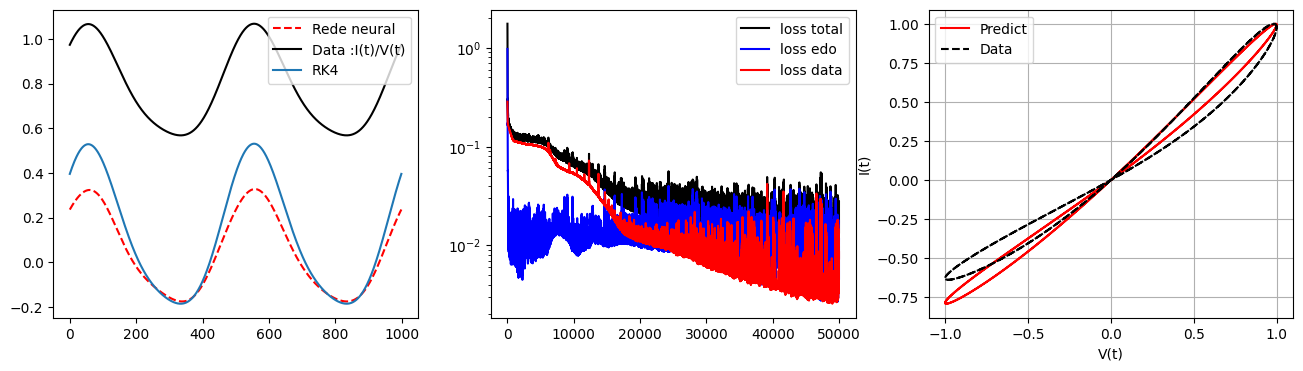


 Predicted : G0 = 0.7462597489356995, c1 =0.3661864995956421, c2 = 0.13820911943912506 , c3 =-0.03693311661481857, c4 = -0.007659890688955784 , tau = 1 , w = 1, V0 = 0.5


In [ ]:
treino(lr_=0.001,neuronio_=5,camadas=2,fun_activation=SineActivation(),epochs=100000,step_size_=20000,G0=1,c1=1.0,c2=1,c3=0,c4=0,tau=1,w=1,V0=0.5)